### Xử lí dữ liệu bộ dataset sau khi được làm sạch

    Import thư viện

In [451]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV ,GridSearchCV
from scipy.stats import loguniform
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

    Đọc dữ liệu được làm sạch từ file clean_data.csv

In [452]:
data = pd.read_csv('./clean data/clean_data.csv')
data

,Date,Open,High,Low,Close,Volume
0,May 21 2015,21.40,21.84,21.40,21.58,82428000
1,May 22 2015,21.58,21.62,21.38,21.38,40412000
2,May 26 2015,21.31,21.35,21.10,21.27,44884000
3,May 27 2015,21.37,21.59,21.25,21.57,44622000
4,May 28 2015,21.49,21.57,21.27,21.33,38248000
...,...,...,...,...,...,...
1759,May 16 2022,113.10,113.99,110.35,110.81,74566000
1760,May 17 2022,113.28,115.80,111.28,115.37,76448000
1761,May 18 2022,111.44,112.85,106.25,107.11,108380000
1762,May 19 2022,106.28,110.03,106.19,107.32,88142000


    Tạo thêm các đặc trưng mới cho bộ dữ liệu

    'Have_Increase' - Giá trị tăng trưởng của cổ phiếu

+ Nếu giá mở cửa trừ giá đóng cửa < 0 -> giá trị sẽ bằng 0

+ Nếu giá mở cửa trừ giá đóng cửa > 0 -> giá trị sẽ bằng 1

In [453]:
conditions = [(data['Open'] - data['Close']) < 0, (data['Open'] - data['Close']) > 0]
values = [0, 1]
data['Have_Increase'] = np.select(conditions, values, default = 1)
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase
0,May 21 2015,21.40,21.84,21.40,21.58,82428000,0
1,May 22 2015,21.58,21.62,21.38,21.38,40412000,1
2,May 26 2015,21.31,21.35,21.10,21.27,44884000,1
3,May 27 2015,21.37,21.59,21.25,21.57,44622000,0
4,May 28 2015,21.49,21.57,21.27,21.33,38248000,1


    'Target' - So sánh giá trị đóng phiên trước và phiên sau

+ Nếu giá trị đóng ngày sau > giá trị đóng ngày trước -> giá trị sẽ bằng 1

+ Nếu giá trị đóng ngày sau < giá tị đóng ngày trước -> giá trị sẽ bằng 0

In [454]:
newfeatures = pd.DataFrame()
newfeatures['Target'] = data.rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
newfeatures.head()

,Target
0,NaN
1,0.0
2,0.0
3,1.0
4,0.0


In [455]:
data = data.shift(1)
data['Target'] = newfeatures['Target']
data = data.iloc[1:]
data.head()

,Date,Open,High,Low,Close,Volume,Have_Increase,Target
1,May 21 2015,21.40,21.84,21.40,21.58,82428000.0,0.0,0.0
2,May 22 2015,21.58,21.62,21.38,21.38,40412000.0,1.0,0.0
3,May 26 2015,21.31,21.35,21.10,21.27,44884000.0,1.0,1.0
4,May 27 2015,21.37,21.59,21.25,21.57,44622000.0,0.0,0.0
5,May 28 2015,21.49,21.57,21.27,21.33,38248000.0,1.0,1.0


    Rolling means
- Đại lượng thể hiện tương quan giữa giá cổ phiếu hiện tại với giá cổ phiếu trung bình trong tuần, quý hoặc năm
- Nếu giá hiện tại cao hơn giá hàng năm thì nghĩa là cố phiếu đang có xu hướng tăng

    Sử dụng phương pháp rolling để tìm ra mean của cột Close với số ngày khác nhau (tuần, quý, năm)

In [456]:
weekly_mean = data.rolling(window=7).mean()['Close']
quarterly_mean = data.rolling(window=90).mean()['Close']
annual_mean = data.rolling(window=365).mean()['Close']

    Tỉ số giữa weekly_mean, quarterly_mean, annual_mean với cột Close

In [457]:
data['weekly_mean'] = weekly_mean / data['Close']
data['quarterly_mean'] = quarterly_mean / data['Close']
data['annual_mean'] = annual_mean / data['Close']

    Thêm tỉ số liên hệ giữa các rolling means với nhau

    Ví dụ : Nếu annual_mean >  weekly_mean -> cổ phiếu có xu hướng tăng

In [458]:
data['annual_weekly_mean'] = data['annual_mean'] / data['weekly_mean']
data['annual_quarterly_mean'] = data['annual_mean'] / data['quarterly_mean']

    Thêm tỉ số giữa giá mở cửa, giá cao, giá thấp và giá đóng cửa trong ngày. 
    
    Ví dụ : Nếu giá cao > giá đóng cửa -> cổ phiếu có xu hướng giảm vào cuối ngày.

In [459]:
data['open_close_ratio'] = data['Open'] / data['Close']
data['high_close_ratio'] = data['High'] / data['Close']
data['low_close_ratio'] = data['Low'] / data['Close']

    Dữ liệu sau khi được thêm mới

In [460]:
data.head(30)

,Date,Open,High,Low,Close,Volume,Have_Increase,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,open_close_ratio,high_close_ratio,low_close_ratio
1,May 21 2015,21.40,21.84,21.40,21.58,82428000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.991659,1.012048,0.991659
2,May 22 2015,21.58,21.62,21.38,21.38,40412000.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,1.009355,1.011225,1.000000
3,May 26 2015,21.31,21.35,21.10,21.27,44884000.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.001881,1.003761,0.992008
4,May 27 2015,21.37,21.59,21.25,21.57,44622000.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.990728,1.000927,0.985165
5,May 28 2015,21.49,21.57,21.27,21.33,38248000.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.007501,1.011252,0.997187
6,May 29 2015,21.36,21.63,21.36,21.46,60322000.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.995340,1.007922,0.995340
7,Jun 01 2015,21.52,21.66,21.31,21.55,45066000.0,0.0,0.0,0.995293,NaN,NaN,NaN,NaN,0.998608,1.005104,0.988863
8,Jun 02 2015,21.50,21.66,21.31,21.55,33378000.0,0.0,1.0,0.995094,NaN,NaN,NaN,NaN,0.997680,1.005104,0.988863
9,Jun 03 2015,21.72,21.92,21.64,21.83,54558000.0,0.0,0.0,0.985276,NaN,NaN,NaN,NaN,0.994961,1.004123,0.991296
10,Jun 04 2015,21.72,21.84,21.46,21.54,50216000.0,1.0,0.0,1.000332,NaN,NaN,NaN,NaN,1.008357,1.013928,0.996286


    Biểu diễn đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm

Text(0.5, 1.0, 'Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm (2017-2022)')

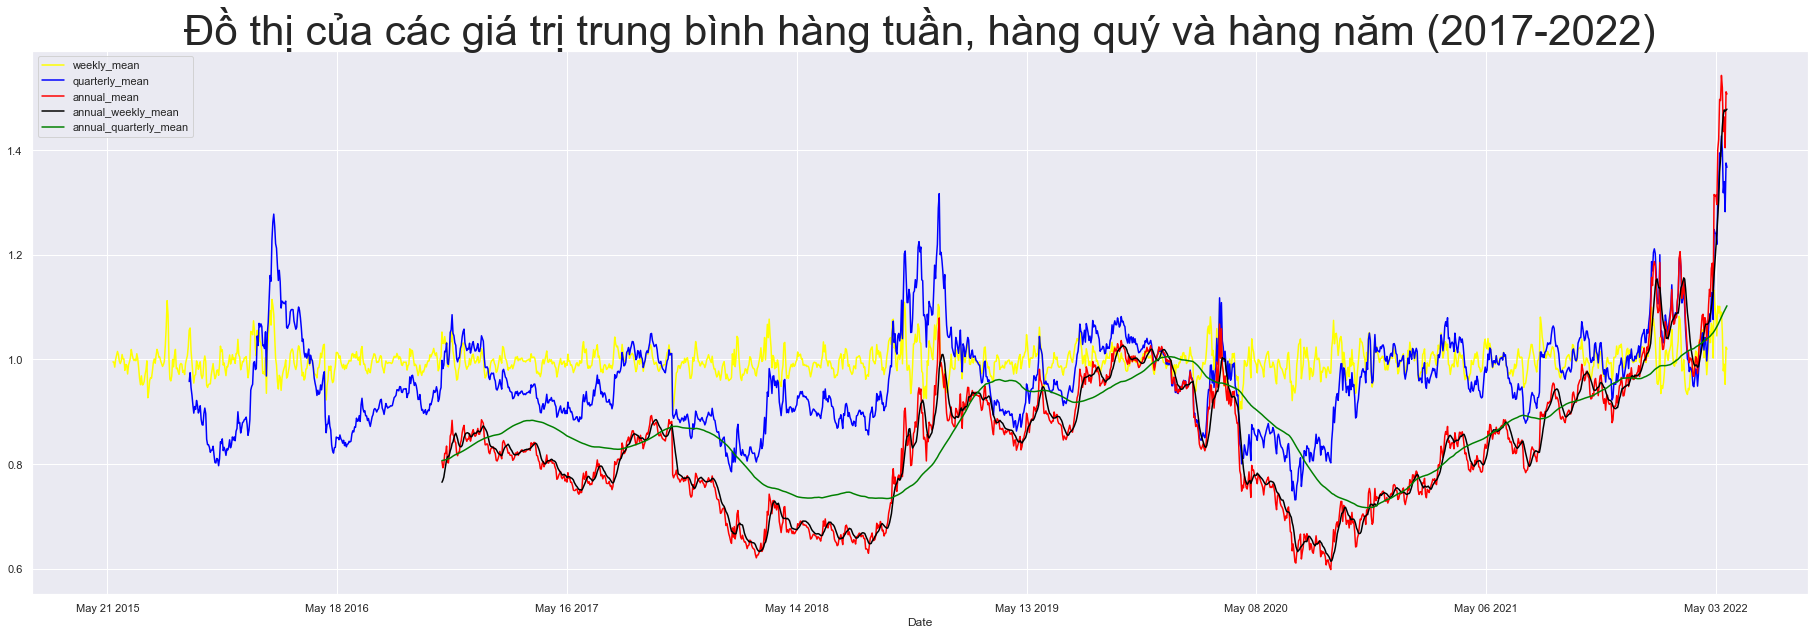

In [461]:
plt.figure(figsize=(70,10))
ax1 = plt.subplot(1, 2, 1)
data.plot.line(x='Date', y='weekly_mean', ax = ax1, color='yellow', label='weekly_mean')
data.plot.line(x='Date', y='quarterly_mean',ax = ax1, color='blue', label='quarterly_mean')
data.plot.line(x='Date', y='annual_mean',ax = ax1, color='red', label='annual_mean')
data.plot.line(x='Date', y='annual_weekly_mean',ax = ax1, color='black', label='annual_weekly_mean')
data.plot.line(x='Date', y='annual_quarterly_mean',ax = ax1, color='green', label='annual_quarterly_mean')
plt.title("Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm (2017-2022)", fontsize=42)

    Ta thấy dữ liệu trống nhiều. Việc tiếp theo ta cần phải xử lý dữ liệu trống
    
    Lựa chon random sample để có thể giữ được độ chính xác của dữ liệu mà tránh làm dữ liệu bị mất đi những đặc trưng 


    Tạo hàm Random Sample

In [462]:
# def random_sample(columname):
#     random_samples = data[columname].dropna().sample(n=data[columname].isnull().sum(),random_state=0)
#     random_samples.index = data[data[columname].isnull()].index
#     data[columname].update(random_samples) 

In [463]:
def random_sample(columname):
    last_index_null = data[columname].isnull().sum()
    # print(last_index_null)
    # print(data['weekly_mean'][last_index_null:last_index_null*2])
    random_sample = data[columname][last_index_null:last_index_null*2].sample(n=last_index_null,random_state=0)
    # print(random_sample_weekly_mean)
    random_sample.index = data[data[columname].isnull()].index
    data[columname].update(random_sample) 

In [464]:
random_sample('weekly_mean')
random_sample('quarterly_mean')
random_sample('annual_mean')
random_sample('annual_weekly_mean')
random_sample('annual_quarterly_mean')

data.head(10)

,Date,Open,High,Low,Close,Volume,Have_Increase,Target,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean,open_close_ratio,high_close_ratio,low_close_ratio
1,May 21 2015,21.40,21.84,21.40,21.58,82428000.0,0.0,0.0,1.015251,0.946311,0.699443,0.714421,0.839172,0.991659,1.012048,0.991659
2,May 22 2015,21.58,21.62,21.38,21.38,40412000.0,1.0,0.0,0.985276,0.885625,0.771026,0.780275,0.871232,1.009355,1.011225,1.000000
3,May 26 2015,21.31,21.35,21.10,21.27,44884000.0,1.0,1.0,0.995094,0.899969,0.877869,0.872993,0.848223,1.001881,1.003761,0.992008
4,May 27 2015,21.37,21.59,21.25,21.57,44622000.0,0.0,0.0,1.000332,0.829089,0.848381,0.858873,0.828177,0.990728,1.000927,0.985165
5,May 28 2015,21.49,21.57,21.27,21.33,38248000.0,1.0,1.0,0.995293,0.884591,0.829324,0.848582,0.842384,1.007501,1.011252,0.997187
6,May 29 2015,21.36,21.63,21.36,21.46,60322000.0,0.0,1.0,1.007762,0.810664,0.630858,0.633213,0.767245,0.995340,1.007922,0.995340
7,Jun 01 2015,21.52,21.66,21.31,21.55,45066000.0,0.0,0.0,0.995293,0.831095,0.822608,0.825789,0.881959,0.998608,1.005104,0.988863
8,Jun 02 2015,21.50,21.66,21.31,21.55,33378000.0,0.0,1.0,0.995094,0.832772,0.772726,0.792598,0.865519,0.997680,1.005104,0.988863
9,Jun 03 2015,21.72,21.92,21.64,21.83,54558000.0,0.0,0.0,0.985276,1.068046,0.817413,0.804396,0.875710,0.994961,1.004123,0.991296
10,Jun 04 2015,21.72,21.84,21.46,21.54,50216000.0,1.0,0.0,1.000332,1.160502,0.803769,0.814261,0.809385,1.008357,1.013928,0.996286


        Biểu diễn đồ thị

Text(0.5, 1.0, 'Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm')

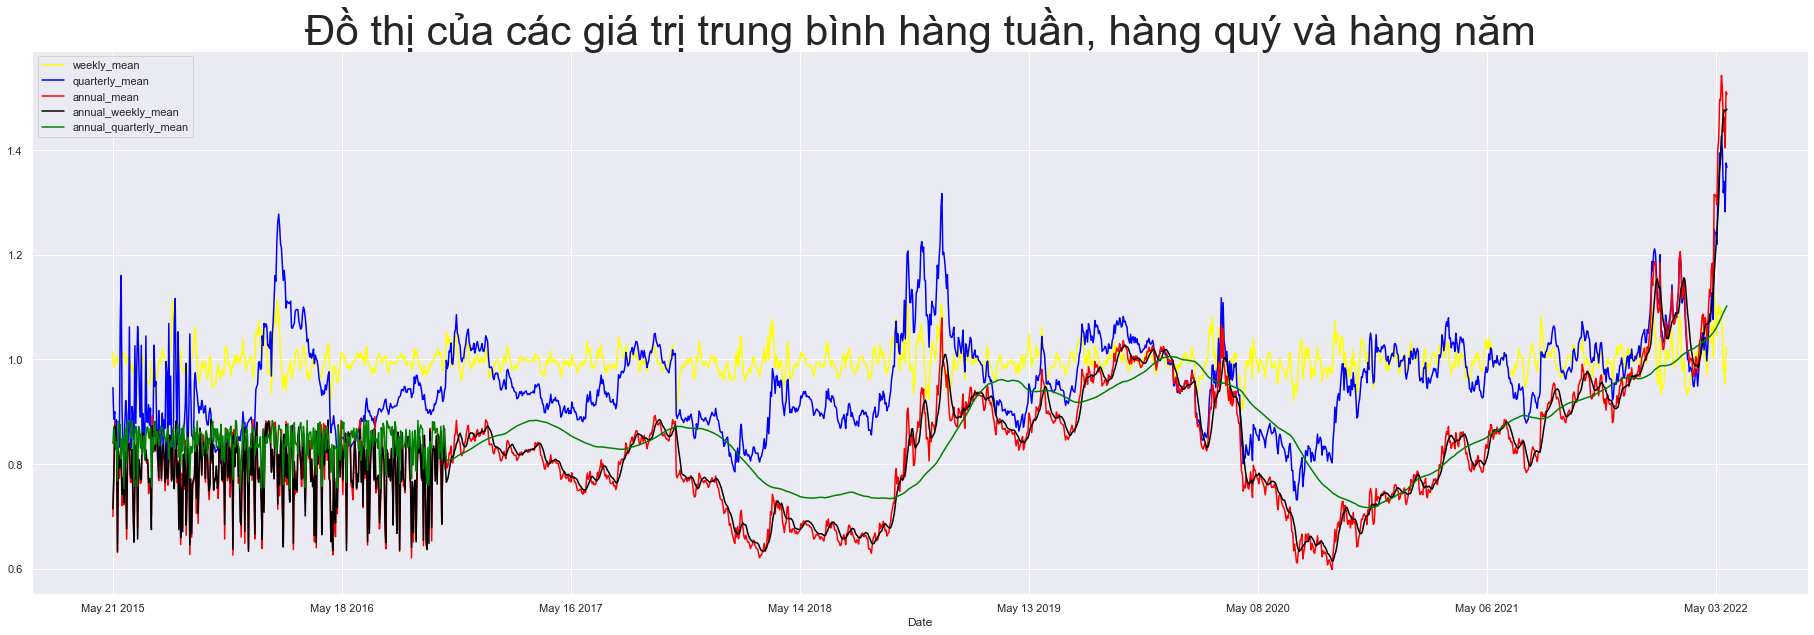

In [465]:
plt.figure(figsize=(70,10))
ax1 = plt.subplot(1, 2, 1)
data.plot.line(x='Date', y='weekly_mean', ax = ax1, color='yellow', label='weekly_mean')
data.plot.line(x='Date', y='quarterly_mean',ax = ax1, color='blue', label='quarterly_mean')
data.plot.line(x='Date', y='annual_mean',ax = ax1, color='red', label='annual_mean')
data.plot.line(x='Date', y='annual_weekly_mean',ax = ax1, color='black', label='annual_weekly_mean')
data.plot.line(x='Date', y='annual_quarterly_mean',ax = ax1, color='green', label='annual_quarterly_mean')
plt.title("Đồ thị của các giá trị trung bình hàng tuần, hàng quý và hàng năm", fontsize=42)

In [466]:
# data_clone = data.iloc[365:]
# data_clone
# data=data_clone
# data

In [467]:
i=6
predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 'Have_Increase']
full_predictors = predictors
# full_predictors = predictors + ['weekly_mean', 'quarterly_mean', 'annual_mean', 'annual_weekly_mean', 'annual_quarterly_mean', 'open_close_ratio', 'high_close_ratio', 'low_close_ratio']
full_predictors

['Open', 'High', 'Low', 'Close', 'Volume', 'Have_Increase']

Logistic

In [468]:

X_train, X_test, y_train, y_test = train_test_split(data[full_predictors], data['Target'],test_size=0.2, random_state = i)

# # Use the same function above for the validation set
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state= i) # 0.25 x 0.8 = 0.2

In [469]:
# def selection_hyperparameters_model(data):
#         # X_train, X_test, y_train, y_test = train_test_split(data[full_predictors], data['Target'], test_size=0.2, random_state=i)
#         model = LogisticRegression()
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#         solvers = ['newton-cg', 'lbfgs', 'liblinear']
#         penalty = ['none', 'l1', 'l2', 'elasticnet']
#         c_values = [100, 10, 1.0, 0.1, 0.01]
#         # define grid search
#         grid = dict(solver=solvers,penalty=penalty,C=c_values)
#         search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
#         result = search.fit(X_train, y_train)
#         return result.best_params_, result.best_score_
        
# best_params_,best_score= selection_hyperparameters_model(data=data)

def Select_Hyperparameters(data):
    model = LogisticRegression()

    space = dict()
    space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
    space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
    space['C'] = loguniform(1e-5, 100)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
    result = search.fit(X_train, y_train)

    return result.best_score_, search.best_params_

best_score_,best_params_= Select_Hyperparameters(data)

In [470]:
print(len(data))
def lRWithHyperparameter_addingParams(data, params):
    # X_train, X_test, y_train, y_test = train_test_split(data[full_predictors], data['Target'], test_size=0.2, random_state=i)
    model = LogisticRegression(C = params['C'], solver = params['solver'], penalty = params['penalty'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)
a = lRWithHyperparameter_addingParams(data,best_params_)
a

1763


0.48158640226628896

Random

In [471]:
# def selection_hyperparameters_model_random_forest(data):
#         # X_train, X_test, y_train, y_test = train_test_split(data[full_predictors], data['Target'], test_size=0.2, random_state=i)
#         model = RandomForestClassifier()
#         n_estimators = [10, 100, 1000]
#         max_features = ['sqrt', 'log2']
#         # define grid search
#         grid = dict(n_estimators=n_estimators,max_features=max_features)
#         cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#         grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
#         result = grid_search.fit(X_train, y_train)
#         return result.best_params_, result.best_score_
        
# best_params_random,best_score_random= selection_hyperparameters_model_random_forest(data=data)

In [472]:
# print(len(data))
# def lRWithHyperparameter_addingParams_random_forest(data, params):

#     # X_train, X_test, y_train, y_test = train_test_split(data[full_predictors], data['Target'], test_size=0.2, random_state=i)
#     model = RandomForestClassifier(n_estimators=best_params_random['n_estimators'], max_features=best_params_random['max_features'])
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return accuracy_score(y_test, y_pred)
# a = lRWithHyperparameter_addingParams_random_forest(data,best_params_random)
# a